__2. Show that observationally estimated internal variability is both highly uncertain and low-biased when estimated from 21-year records.__

- Use the forced CESM1-LE members to generate a multivariate normal distribution showing that there is a large possible range of internal variability at 20 years
- Plot the internal variability from CERES OLR obs., I anticipate that they will fall within the CESM1-LE range, preventing us from invalidating the model
- Plot a "true" internal variability from the CESM1 1800-yr control run, demonstrating that a short record also biases the internal variability low for both characteristics ($\tau_{var}$ and $\sigma_{var}$).

## Load Data

### Do imports

In [152]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

### Load pre-processed timeseries

Model output.

In [2]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

In [3]:
cesm1_ensresponse_olr = cesm1_ensresponse_ds['FLUT']

Observations of OLR from CERES.

In [4]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/'

In [5]:
# Open Arctic OLR timeseries
ceres_arc_savedir = '/glade/work/jonahshaw/obs/CERES/arc_proc'

ceres_arc_tseries = xr.open_dataset('%s/%s' % (ceres_arc_savedir,'CERES_EBAF4.1_allvars_200003_202202_ArcticTimeSeries.nc'))

In [6]:
ceres_arc_olr = ceres_arc_tseries['toa_lw_all_mon']

del ceres_arc_tseries

Get the variables.

In [7]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data,testing=False):
    ''' Standardize the data. '''
    
    # if data.std()==0: # edge case that the standard deviation is zero
    if np.isclose(data.std(),0,atol=1e-5): # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    if testing:
        print(data)
        print(data_std)
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [8]:
def linear_polyfit(ds,dim='time.year'):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1)) # this should work if you use xr.DataArray?
    '''
    # ds['time'] = ds[dim] # reassign the time coordinate so that the polyfit gets units right
    ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right, this is the old code
    
    return ds.polyfit(dim='time',deg=1)

In [9]:
def calc_tauvar2(autocorr,alpha=0.95):
    '''
    Calculate the autocorrelation time using Leroy (2008), with a selection of significant lags following Phojan.
    Taking sample coefficients at all available lags in estimating Leroy’s uncertainty of the trend will provide zero uncertainty;
    specifically, [the sum of the lagged correlations] is zero. Therefore, it is necessary to set up the criterion to determine which
    sample autocorrelation coefficients to include in the computation. The criterion used in this study is to
    include only the statistically significant [at 95%] coefficients up to 10 log10(T) lags in the summation.
    '''
    
    # the length of the autocorrelation is equal to the length of the timeseries
    N = len(autocorr)
    
    # lags up to "10 log10(T) lags in the summation"
    max_lag = int(10*np.log10(N))
    
    # Select autocorrelation only within a "max lag" of lag-0
    valid_autocorrs = autocorr[N//2-max_lag:N//2+max_lag+1]
    
    # calculate a critical t-statistic
    t_crit = stats.t.ppf((1+alpha)/2,df=N)

    # Calculate the statistical significance bound
    # $$ bound = t_{crit} / \sqrt{N}
    correlation_bound = t_crit / np.sqrt(N)
    
    # check if the autocorrelations are significant
    is_sig_bool = np.abs(valid_autocorrs) > correlation_bound

    # select the significant correlations and sum them to get the correlation time
    tau_var = np.sum(valid_autocorrs[is_sig_bool])
    
    return tau_var

In [10]:
def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_lag1_autocorr(data):
    
    autocorr = calc_autocorr(data)
    
    _lag1_index = len(autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = autocorr[_lag1_index] # Get the lag-1 autocorrelation
    
    return xr.DataArray(_lag1_autocorr) # convert back to a dataarray object so xarray can try to concatenate

def calc_tauvar_wrapper(data):
    
    return xr.DataArray(calc_tauvar2(calc_autocorr(data)))

### Do calculations

In [11]:
tsel21 = slice('2001-01-01','2021-12-31')
tsel50 = slice('2001-01-01','2050-12-31')

#### Calculate $\tau_{var}$ and $\sigma_{var}$ from the observations (21-years)

With only 21 data points, I will use the lag-1 autocorrelation method (Weatherhead) for estimating $\tau_{var}$.

$$ \tau_{var} = \frac{1 + \rho}{1 - \rho} $$

In [12]:
ceres_ann = ceres_arc_olr.sel(time=tsel21).groupby('time.year').mean(dim='time')

Calculate our noise characteristics for the raw (undetrended) data

In [13]:
_lag1_ceres_raw = calc_lag1_autocorr(ceres_ann)

_tauvar_ceres_raw = (1 + _lag1_ceres_raw) / (1 - _lag1_ceres_raw)

print('Correlation time of undetrended data %.2f' % _tauvar_ceres_raw.values)
print('Standard deviation of undetrended data %.2f' % np.std(ceres_ann).values)

Correlation time of undetrended data 1.20
Standard deviation of undetrended data 1.07


Calculate the noise characteristics for the detrended data (correctly)

In [14]:
def simple_detrend(tseries,dim):
    '''
    Pass a timeseries and the dimension to detrend along.
    '''
    
    polyfit = tseries.polyfit(dim=dim,deg=1) # take a linear fit
    slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
    
    linearized_tseries = slopes.sel(degree=1)*tseries[dim] + slopes.sel(degree=0) # construct the linear fit
    detrended_tseries  = tseries - linearized_tseries # remove the linear fit to detrend the timeseries
    
    return detrended_tseries

In [341]:
ceres_ann.year

<xarray.DataArray 'year' (year: 21)>
array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])
Coordinates:
  * year     (year) int64 2001 2002 2003 2004 2005 ... 2017 2018 2019 2020 2021

In [343]:
ceres_detrend = simple_detrend(ceres_ann,dim='year')
ceres_deforce = ceres_ann - lens_olr_ann21_FR # out of order, this won't work when I restart the kernel lol

In [344]:
lag1_ceres = calc_lag1_autocorr(ceres_detrend)
lag1_ceres_deforce = calc_lag1_autocorr(ceres_deforce)

tauvar_ceres = (1 + lag1_ceres) / (1 - lag1_ceres)
stddev_ceres = np.std(ceres_detrend)

tauvar_ceres_deforce = (1 + lag1_ceres_deforce) / (1 - lag1_ceres_deforce)
stddev_ceres_deforce = np.std(ceres_deforce)

print('Correlation time of undetrended data %.2f' % tauvar_ceres.values)
print('Standard deviation of undetrended data %.2f' % stddev_ceres.values)

print('Correlation time of undetrended data %.2f' % tauvar_ceres_deforce.values)
print('Standard deviation of undetrended data %.2f' % stddev_ceres_deforce.values)

Correlation time of undetrended data 0.68
Standard deviation of undetrended data 0.94
Correlation time of undetrended data 0.77
Standard deviation of undetrended data 1.03


__Both are significantly reduced.__

#### Repeat with the CESM1-LE data

But now I will only use the detrended data. Test durations of 21 and 50 years to demonstrate that we need even longer.

In [17]:
lens_olr_ann21 = cesm1_ensresponse_olr.sel(time=tsel21).groupby('time.year').mean(dim='time')

In [18]:
lens_olr_detrend21 = simple_detrend(lens_olr_ann21,dim='year')

In [19]:
lens_lag1s_21 = lens_olr_detrend21.groupby('ens').map(calc_lag1_autocorr)

lens_tauvars_21 = (1 + lens_lag1s_21) / (1 - lens_lag1s_21)
lens_stddevs_21 = lens_olr_detrend21.std(dim='year')

In [266]:
# Calculate these values for the forced ensemble minus the forced response
# Compute the forced response 2001-2021 and subtract it, then compute our noise statistics

lens_olr_ann21_FR = lens_olr_ann21.mean(dim='ens') # compute a forced response
lens_olr_ann21_deforced = lens_olr_ann21 - lens_olr_ann21_FR.broadcast_like(lens_olr_ann21) # remove the forced response from each member

lens_lag1s_deforced21 = lens_olr_ann21_deforced.groupby('ens').map(calc_lag1_autocorr)

lens_tauvars_deforced21 = (1 + lens_lag1s_deforced21) / (1 - lens_lag1s_deforced21)
lens_stddevs_deforced21 = lens_olr_ann21_deforced.std(dim='year')

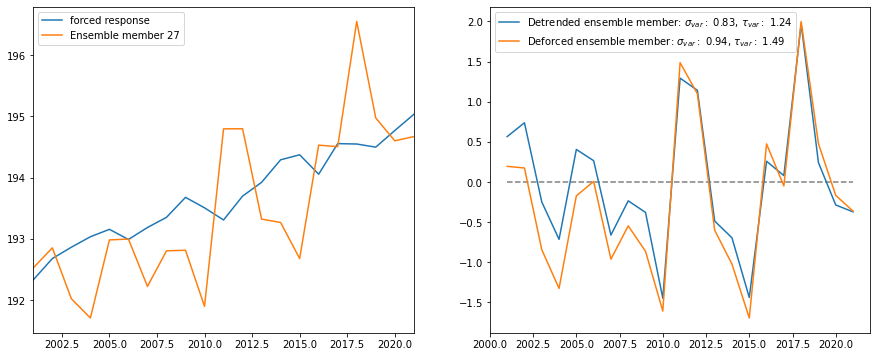

In [348]:
fig_m3,axs_m3 = plt.subplots(1,2,figsize=(15,6))

# 9,13,27 is weird
ens_example = lens_olr_ann21.sel(ens=31)

axs_m3[0].plot(lens_olr_ann21_FR.year,lens_olr_ann21_FR,label='forced response')
axs_m3[0].plot(ens_example.year,ens_example,label='Ensemble member 27')

axs_m3[0].set_xlim((2001,2021))
axs_m3[0].legend()

ens_example_detrend = simple_detrend(ens_example,dim='year')
ens_example_deforce = ens_example-lens_olr_ann21_FR

detrended_lag1 = calc_lag1_autocorr(ens_example_detrend)
deforced_lag1  = calc_lag1_autocorr(ens_example_deforce)

detrended_tauvar = (1+detrended_lag1) / (1-detrended_lag1)
deforced_tauvar = (1+deforced_lag1) / (1-deforced_lag1)

detrended_stddev = np.std(ens_example_detrend)
deforced_stddev  = np.std(ens_example_deforce)

axs_m3[1].plot(ens_example_detrend.year,ens_example_detrend,
               label=r'Detrended ensemble member: $\sigma_{var}:$ %.2f, $\tau_{var}:$ %.2f' % (detrended_stddev,detrended_tauvar))
axs_m3[1].plot(ens_example_deforce.year,ens_example_deforce,
               label=r'Deforced ensemble member: $\sigma_{var}:$ %.2f, $\tau_{var}:$ %.2f' % (deforced_stddev,deforced_tauvar))
axs_m3[1].hlines(0,2001,2021,color='black',alpha=0.5,linestyle='dashed')
axs_m3[1].legend()

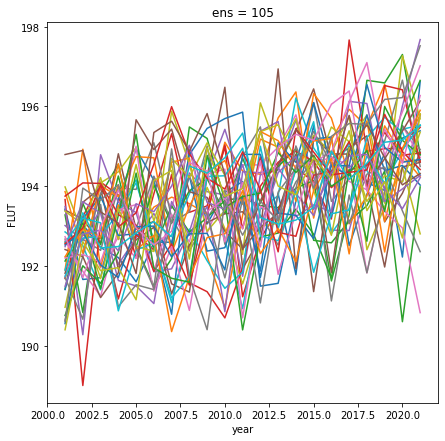

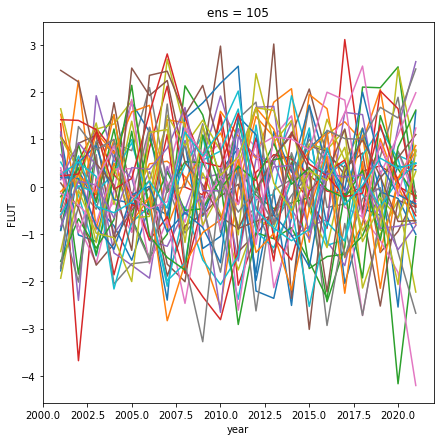

In [263]:
fig1,ax1 = plt.subplots(1,1,figsize=(7,7))
fig2,ax2 = plt.subplots(1,1,figsize=(7,7))

for i,j in zip(lens_olr_ann21,lens_olr_ann21_deforced):
    i.plot(ax=ax1)
    j.plot(ax=ax2)

### Make fake instructional figure

In [477]:
len(redseries_list)

61

In [529]:
tlength = 50
tspace = np.arange(1,tlength+1)

slope = 2
expterm = 0.07

fake_FR = slope*tspace + np.exp(tspace*expterm)
fake_sigmae = 50000 # term summarizes the autocorrelative nature of the natural variability
noise = np.random.normal(0,np.sqrt(fake_sigmae),tlength)

# Create red noise using code from Jen's class:
# applicationlab5/ATOC5860_applicationlab5_synthetic_data_with_filters.ipynb
alpha = 0.8 # autocorrelation

factor = np.sqrt(1.-alpha*alpha)
rednoise_multiplier = 40 # arbitrary multiplier

redseries_list = []
last_val = factor*np.random.randn() # seed with a random value
redseries_list.append(last_val)
for i in range(tlength+9): # warm up with ten additional points   
    # update last_val
    last_val = last_val*alpha + factor*np.random.randn()
    redseries_list.append(last_val)

red_noise = np.array(redseries_list[10:])*rednoise_multiplier # remove the warm-up values and turn into a np.array object

fake_ens = fake_FR + noise
fake_ens_red = fake_FR + red_noise

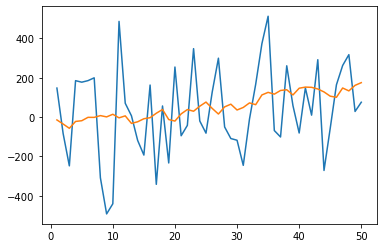

In [530]:
plt.plot(tspace,fake_ens)
plt.plot(tspace,fake_ens_red)

In [531]:
fake_deforced = noise
fake_deforced_red = red_noise

fake_ens_polyfit = np.polyfit(tspace,fake_ens,deg=1)
fake_ens_linearized = fake_ens_polyfit[1] + tspace*fake_ens_polyfit[0]
fake_detrended = fake_ens - fake_ens_linearized

fake_ens_red_polyfit = np.polyfit(tspace,fake_ens_red,deg=1)
fake_ens_red_linearized = fake_ens_red_polyfit[1] + tspace*fake_ens_red_polyfit[0]
fake_red_detrended = fake_ens_red - fake_ens_red_linearized

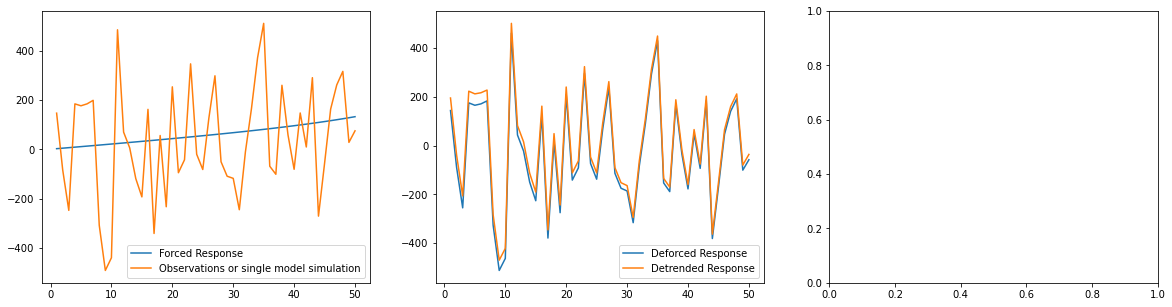

In [532]:
fake_fig,fake_axs = plt.subplots(1,3,figsize=(20,5))

fake_axs[0].plot(tspace,fake_FR,label='Forced Response')
fake_axs[0].plot(tspace,fake_ens,label='Observations or single model simulation')
# fake_axs[0].plot(tspace,fake_ens_red,label='Observations or single model simulation (red)')
fake_axs[0].legend()

fake_axs[1].plot(tspace,noise,label='Deforced Response')
fake_axs[1].plot(tspace,fake_detrended,label='Detrended Response')
fake_axs[1].legend()

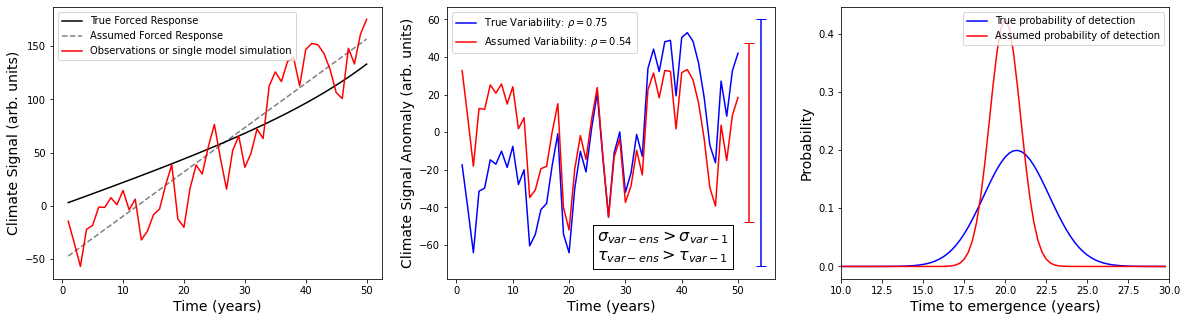

In [609]:
fake_fig,fake_axs = plt.subplots(1,3,figsize=(20,5))

fake_axs[0].plot(tspace,fake_FR,label='True Forced Response',color='black')
fake_axs[0].plot(tspace,fake_ens_red_linearized,label='Assumed Forced Response',color='black',alpha=0.5,linestyle='dashed')
fake_ens_red_linearized
# fake_axs[0].plot(tspace,fake_ens,label='Observations or single model simulation')
fake_axs[0].plot(tspace,fake_ens_red,label='Observations or single model simulation',color='red')
fake_axs[0].legend()

fake_axs[0].set_xlabel('Time (years)',fontsize=14)
fake_axs[0].set_ylabel('Climate Signal (arb. units)',fontsize=14)

# calculate tau_var to show how the linear correction reduces it
lag1_red_deforced  = calc_lag1_autocorr(red_noise)
lag1_red_detrended = calc_lag1_autocorr(fake_red_detrended)

tauvar_red_deforced  = (1 + lag1_red_deforced)  / (1 - lag1_red_deforced)
tauvar_red_detrended = (1 + lag1_red_detrended) / (1 - lag1_red_detrended)

fake_axs[1].plot(tspace,red_noise,label=r'True Variability: $\rho = %.2f$' % lag1_red_deforced,color='blue')
fake_axs[1].plot(tspace,fake_red_detrended,label=r'Assumed Variability: $\rho = %.2f$' % lag1_red_detrended,color='red')

fake_axs[1].errorbar(x=52,y=np.mean(fake_red_detrended),yerr=2*np.std(fake_red_detrended),color='red',capsize=5)
fake_axs[1].errorbar(x=54,y=np.mean(red_noise),yerr=2*np.std(red_noise),color='blue',capsize=5)
# fake_axs[1].set_xlim((0,57))

fake_axs[1].set_xlabel('Time (years)',fontsize=14)
fake_axs[1].set_ylabel('Climate Signal Anomaly (arb. units)',fontsize=14)

props = dict(facecolor='white', alpha=1)
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fake_axs[1].text(25,-68,r'''$\sigma_{var-ens} > \sigma_{var-1}$
$\tau_{var-ens} > \tau_{var-1}$''',fontsize=16,bbox=props)

fake_axs[1].legend()

detectspace = np.arange(10,30,0.25) # 40 years arbitrarily

# Take values from OLR (ensemble member 31 in the synthetic debunking file)

true_center = 20.69
true_stddev = 2

assumed_center = 20
assumed_stddev = 0.94

true_detection_distribution = 1/(np.sqrt(2*np.pi*true_stddev**2)) * np.exp(-1*(true_center - detectspace)**2 / (2*true_stddev**2))
assumed_detection_distribution = 1/(np.sqrt(2*np.pi*assumed_stddev**2)) * np.exp(-1*(assumed_center - detectspace)**2 / (2*assumed_stddev**2))

fake_axs[2].plot(detectspace,true_detection_distribution,label='True probability of detection',color='blue')
fake_axs[2].plot(detectspace,assumed_detection_distribution,label='Assumed probability of detection',color='red')

fake_axs[2].set_xlabel('Time to emergence (years)',fontsize=14)
fake_axs[2].set_ylabel('Probability',fontsize=14)

fake_axs[2].set_xlim((10,30))
fake_axs[2].legend()

In [ ]:
plt.fill_between

Text(11, 0.4, 'b')

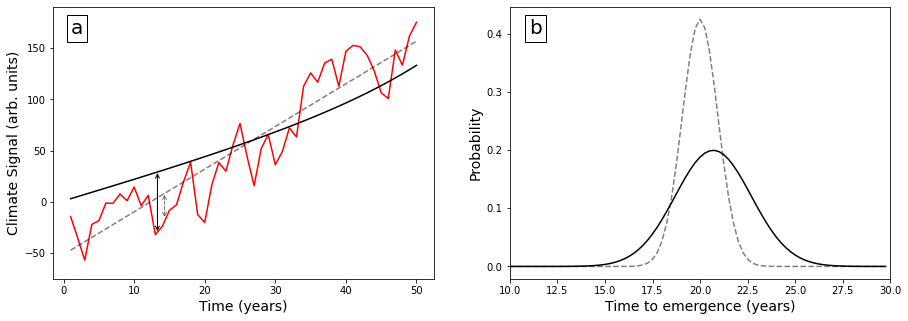

In [667]:
fake_fig,fake_axs = plt.subplots(1,2,figsize=(15,5))

props = dict(facecolor='white', alpha=1)

fake_axs[0].plot(tspace,fake_ens_red,label='Observations or single model simulation',color='red')
fake_axs[0].plot(tspace,fake_FR,label='True Forced Response',color='black')
fake_axs[0].plot(tspace,fake_ens_red_linearized,label='Assumed Forced Response',color='black',alpha=0.5,linestyle='dashed')

fake_axs[0].annotate("", xy=(13.3, 30), xytext=(13.3, -30.5),
            arrowprops=dict(arrowstyle="<->"))
fake_axs[0].annotate("", xy=(14.3, -17), xytext=(14.3, 9),
            arrowprops=dict(arrowstyle="<->",linestyle='dashed',alpha=0.5))

# fake_axs[0].fill_between(tspace,fake_FR,fake_ens_red,alpha=0.2,color='red')
# fake_axs[0].fill_between(tspace,fake_ens_red_linearized,fake_ens_red,alpha=0.2,color='blue')


# fake_axs[0].legend(loc='lower right')

fake_axs[0].set_xlabel('Time (years)',fontsize=14)
fake_axs[0].set_ylabel('Climate Signal (arb. units)',fontsize=14)

fake_axs[0].set_ylim((-75,190))

# fake_axs[0].text(30,-44,r'''$\sigma_{var-ens} > \sigma_{var-1}$
# $\tau_{var-ens} > \tau_{var-1}$''',fontsize=16,bbox=props)

# calculate tau_var to show how the linear correction reduces it
lag1_red_deforced  = calc_lag1_autocorr(red_noise)
lag1_red_detrended = calc_lag1_autocorr(fake_red_detrended)

tauvar_red_deforced  = (1 + lag1_red_deforced)  / (1 - lag1_red_deforced)
tauvar_red_detrended = (1 + lag1_red_detrended) / (1 - lag1_red_detrended)

detectspace = np.arange(10,30,0.25) # 40 years arbitrarily

# Take values from OLR (ensemble member 31 in the synthetic debunking file)
true_center = 20.69
true_stddev = 2

assumed_center = 20
assumed_stddev = 0.94

true_detection_distribution = 1/(np.sqrt(2*np.pi*true_stddev**2)) * np.exp(-1*(true_center - detectspace)**2 / (2*true_stddev**2))
assumed_detection_distribution = 1/(np.sqrt(2*np.pi*assumed_stddev**2)) * np.exp(-1*(assumed_center - detectspace)**2 / (2*assumed_stddev**2))

fake_axs[1].plot(detectspace,true_detection_distribution,label='True probability of detection',color='black')
fake_axs[1].plot(detectspace,assumed_detection_distribution,label='Assumed probability of detection',color='black',linestyle='dashed',alpha=0.5)

fake_axs[1].set_xlabel('Time to emergence (years)',fontsize=14)
fake_axs[1].set_ylabel('Probability',fontsize=14)

fake_axs[1].set_xlim((10,30))
# fake_axs[1].legend()

fake_axs[0].text(1,164,'a',fontsize=20,bbox=props)
fake_axs[1].text(11,0.4,'b',fontsize=20,bbox=props)


In [668]:
to_png(fake_fig,'methodfig_singlerealization',dpi=300,bbox_inches='tight')

The second panel here is not very clear, I think I need more autocorrelation.

In [20]:
lens_olr_ann50 = cesm1_ensresponse_olr.sel(time=tsel50).groupby('time.year').mean(dim='time')

In [21]:
lens_olr_detrend50 = simple_detrend(lens_olr_ann50,dim='year')

In [22]:
lens_lag1s_50 = lens_olr_detrend50.groupby('ens').map(calc_lag1_autocorr)

lens_tauvars_50 = (1 + lens_lag1s_50) / (1 - lens_lag1s_50)
lens_stddevs_50 = lens_olr_detrend50.std(dim='year')

In [265]:
# Calculate these values for the forced ensemble minus the forced response
# Compute the forced response 2001-2021 and subtract it, then compute our noise statistics

lens_olr_ann50_FR = lens_olr_ann50.mean(dim='ens') # compute a forced response
lens_olr_ann50_deforced = lens_olr_ann50 - lens_olr_ann50_FR.broadcast_like(lens_olr_ann50) # remove the forced response from each member

lens_lag1s_deforced50 = lens_olr_ann50_deforced.groupby('ens').map(calc_lag1_autocorr)

lens_tauvars_deforced50 = (1 + lens_lag1s_deforced50) / (1 - lens_lag1s_deforced50)
lens_stddevs_deforced50 = lens_olr_ann50_deforced.std(dim='year')

This just indicates that the large ensemble is consistent with observations and that the 21-years of observations give a very uncertain value for the noise characteristics.

In [23]:
print(lens_tauvars_21.mean())
print(lens_tauvars_21.min())
print(lens_tauvars_21.max())
print(lens_stddevs_21.mean())

<xarray.DataArray ()>
array(1.10677516)
<xarray.DataArray ()>
array(0.40741051)
<xarray.DataArray ()>
array(1.95161173)
<xarray.DataArray ()>
array(1.07003654)


In [24]:
print(lens_tauvars_50.mean())
print(lens_tauvars_50.min())
print(lens_tauvars_50.max())
print(lens_stddevs_50.mean())

<xarray.DataArray ()>
array(1.31381584)
<xarray.DataArray ()>
array(0.72827686)
<xarray.DataArray ()>
array(2.16438093)
<xarray.DataArray ()>
array(1.17756777)


The confidence doesn't really change, but the values shift higher because we're filtering out fewer frequencies.

#### Calculate the "true" noise characteristics using the PI-Control simulation

In [25]:
pic_olr_ann = cesm1_pic_ds['FLUT'].groupby('time.year').mean(dim='time')

In [26]:
pic_olr_detrend = simple_detrend(pic_olr_ann,dim='year')

In [27]:
pic_lag1 = calc_lag1_autocorr(pic_olr_detrend)

pic_tauvar = (1 + pic_lag1) / (1 - pic_lag1)
pic_stddev = pic_olr_detrend.std(dim='year')

#### Calculate a bivariate normal distribution on $\tau_{var}$ and $\sigma_{var}$

In [338]:
##### construct a covariance matrix, not sure why the diagonals are not exactly the squared standard deviations though..
cov_matrix21 = np.cov(lens_tauvars_21,lens_stddevs_21)
print(cov_matrix21)
#^ the noise characteristics are essentially uncorrelated, so we don't need a bivariate approach
# https://www.geeksforgeeks.org/visualizing-the-bivariate-gaussian-distribution-in-python/

# plt.style.use('seaborn-dark')
# plt.rcParams['figure.figsize']=14,6
sns.reset_orig()

fig = plt.figure(figsize=(14,6))

# Initializing the random seed
random_seed=1000

# Setting mean of the distribution
mean = np.array([np.mean(lens_tauvars_21),np.mean(lens_stddevs_21)])

distr = stats.multivariate_normal(cov=cov_matrix21, mean=mean,
                                seed=random_seed)

# Generating a meshgrid complacent with
# the 3-sigma boundary
mean_1, mean_2 = mean[0], mean[1]
sigma_1, sigma_2 = cov_matrix21[0,0], cov_matrix21[1,1]

# Create a sampling space
x = np.linspace(-3*sigma_1+mean[0], 3*sigma_1+mean[0], num=100)
y = np.linspace(-3*sigma_2+mean[1], 3*sigma_2+mean[1], num=100)
X, Y = np.meshgrid(x,y)

# Generating the density function
# for each point in the meshgrid (could be vectorized)
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
        
# Plotting contour plots
fig,ax = plt.subplots(1,1,figsize=(8,8))
# im = plt.contourf(X, Y, pdf, cmap='viridis')
# plt.contour(X, Y, pdf)#,levels=[0.22])
# fig.colorbar(im)

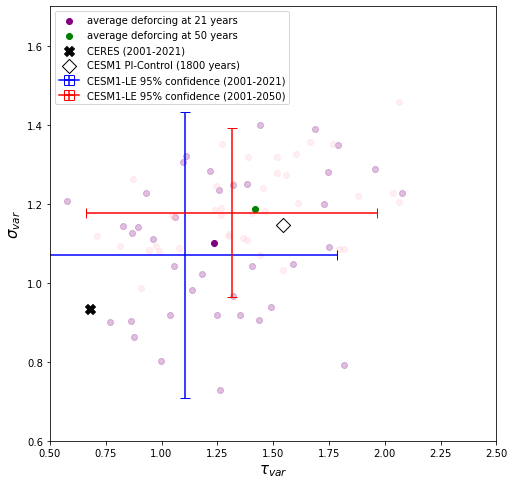

In [339]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

# plt.scatter(lens_tauvars_21,lens_stddevs_21,alpha=0.25,color='blue')
# plt.scatter(lens_tauvars_50,lens_stddevs_50,alpha=0.25,color='red')
plt.scatter(lens_tauvars_deforced21,lens_stddevs_deforced21,alpha=0.25,color='purple')
plt.scatter(lens_tauvars_deforced21.mean(),lens_stddevs_deforced21.mean(),alpha=1,color='purple',label='average deforcing at 21 years')
plt.scatter(lens_tauvars_deforced50,lens_stddevs_deforced50,alpha=0.25,color='pink')
plt.scatter(lens_tauvars_deforced50.mean(),lens_stddevs_deforced50.mean(),alpha=1,color='green',label='average deforcing at 50 years')
plt.scatter(tauvar_ceres,stddev_ceres,marker='X',color='black',label='CERES (2001-2021)',s=100)

# plt.errorbar(pic_tauvar,pic_stddev,xerr=0.25,yerr=0.05,capsize=5,color='red',alpha=0.6,label='Uncertainty after 400 years')#,solid_capstyle='butt')
plt.scatter(pic_tauvar,pic_stddev,marker='D',color='white',edgecolors='black',s=100,label='CESM1 PI-Control (1800 years)')

plt.errorbar(np.mean(lens_tauvars_21), np.mean(lens_stddevs_21),
             xerr=2*lens_tauvars_21.std(),yerr=2*lens_stddevs_21.std(),
             capsize=5,label='CESM1-LE 95% confidence (2001-2021)',color='blue')#,solid_capstyle='butt')
plt.errorbar(np.mean(lens_tauvars_50), np.mean(lens_stddevs_50),
             xerr=2*lens_tauvars_50.std(),yerr=2*lens_stddevs_50.std(),
             capsize=5,label='CESM1-LE 95% confidence (2001-2050)',color='red')#,solid_capstyle='butt')
# plt.errorbar(mean[0], mean[1],xerr=sigma_1,yerr=sigma_2,capsize=5)#,solid_capstyle='butt')

ax.set_xlabel(r"$\tau_{var}$",fontsize=15)
ax.set_ylabel("$\sigma_{var}$",fontsize=15)

ax.set_xlim(0.5,2.5)
ax.set_ylim(0.6,1.7)

ax.legend(fontsize=10)
# ax.set_title(f'Covariance between x1 and x2 = {cov_val[idx]}')
# plt.tight_layout()
# plt.show()

With these values, using the CESM1-LE would predict emergence times 50% longer than the CERES record.

But we're also seeing that the deforcing effect appears to be smaller than the simple longer time effect.

In [45]:
(pic_stddev / stddev_ceres)**(2/3)

<xarray.DataArray ()>
array(1.14623202)

In [43]:
(pic_tauvar / tauvar_ceres)**(1/3)

<xarray.DataArray ()>
array(1.31633014)

In [51]:
1.15**(2/3)

1.097653399825006

In [47]:
1.1**3

1.3310000000000004

In [48]:
1.33**(1/3)

1.0997244488862667

In [ ]:
x**(1/3) = 1.1

In [46]:
1.14*1.32

1.5048

This is boring and not as clear reading as I expected...

How do these values affect detection times? We can look at the expression for the detection time and look at a fractional change from the noise characteristics.

$$ T^* = \left[\frac{3.3s^2}{|{m}|^2}\sigma_{var}^2 \tau_{var} \right] ^{1/3} $$

So we would care about the ratio of the second terms' cubic root.

In [33]:
val_ceres = (stddev_ceres**2 * tauvar_ceres)**(1/3)
val_lens_21mean = (lens_stddevs_21.mean()**2 * lens_tauvars_21.mean())**(1/3)

# print(lens_tauvars_21.mean())
# print(lens_tauvars_21.min())
# print(lens_tauvars_21.max())
# print(lens_stddevs_21.mean())

val_pic = (pic_stddev**2 * pic_tauvar)**(1/3)

In [31]:
val_ceres / val_pic

<xarray.DataArray ()>
array(0.66276969)

In [32]:
val_pic / val_ceres

<xarray.DataArray ()>
array(1.50881976)

In [34]:
val_pic / val_lens_21mean

<xarray.DataArray ()>
array(1.17139636)

Using the observed variability will give annual OLR detection times that are 66% of the values estimated from the "true" noise characteristics. This is a big underestimation. Similarly, the "true" noise values will give predictions 50% longer than those estimated using observations.

On average, the mean 21-year noise values are still notably less than the "true" values, but would only underestimate emergence by ~17%.

In [62]:
pic_olr_ann = cesm1_pic_ds['FLUT'].groupby('time.year').mean()
pic_olr_sep = cesm1_pic_ds['FLUT'].sel(time=cesm1_pic_ds['time.month']==9).groupby('time.year').mean()
pic_olr_apr = cesm1_pic_ds['FLUT'].sel(time=cesm1_pic_ds['time.month']==4).groupby('time.year').mean()

(400.0, 600.0)

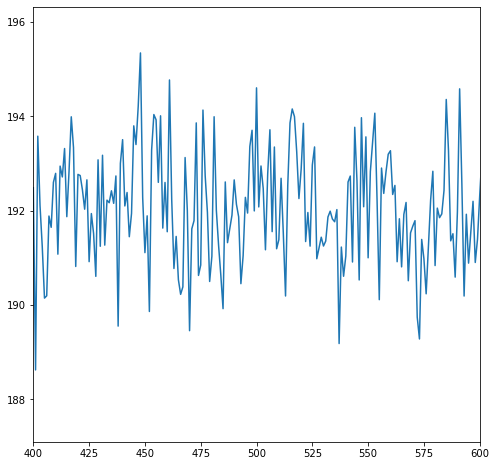

In [69]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(pic_olr_ann.year,pic_olr_ann)
# ax.plot(pic_olr_sep.year,pic_olr_sep)
# ax.plot(pic_olr_apr.year,pic_olr_apr)
ax.set_xlim(400,600)

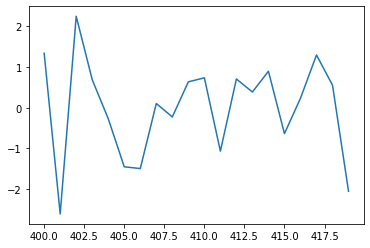

In [83]:
plt.plot(pic_olr_ann_detrend.year,pic_olr_ann_detrend)


(570.0, 650.0)

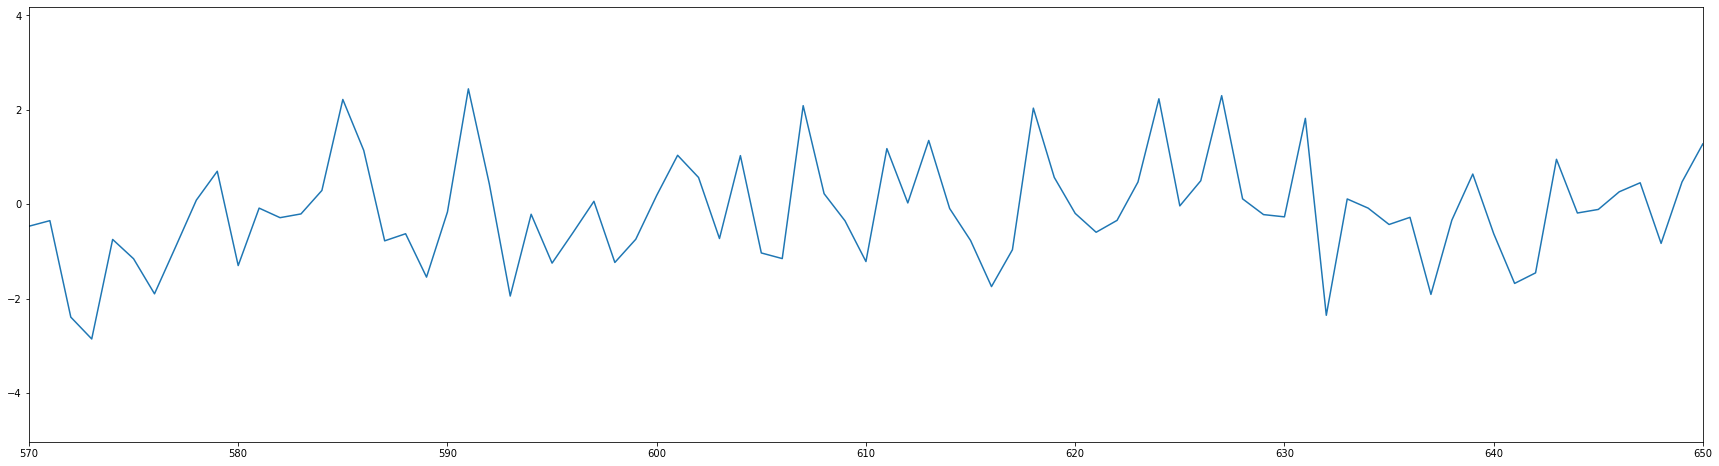

In [112]:
pic_olr_ann_detrend = simple_detrend(pic_olr_ann,dim='year')

fig,ax = plt.subplots(1,1,figsize=(30,8))

ax.plot(pic_olr_ann.year,pic_olr_ann-pic_olr_ann.mean())
# ax.plot(pic_olr_ann_detrend.year,pic_olr_ann_detrend)
# ax.plot(pic_olr_sep.year,pic_olr_sep)
# ax.plot(pic_olr_apr.year,pic_olr_apr)

ax.set_xlim(570,650)

(551.0, 651.0)

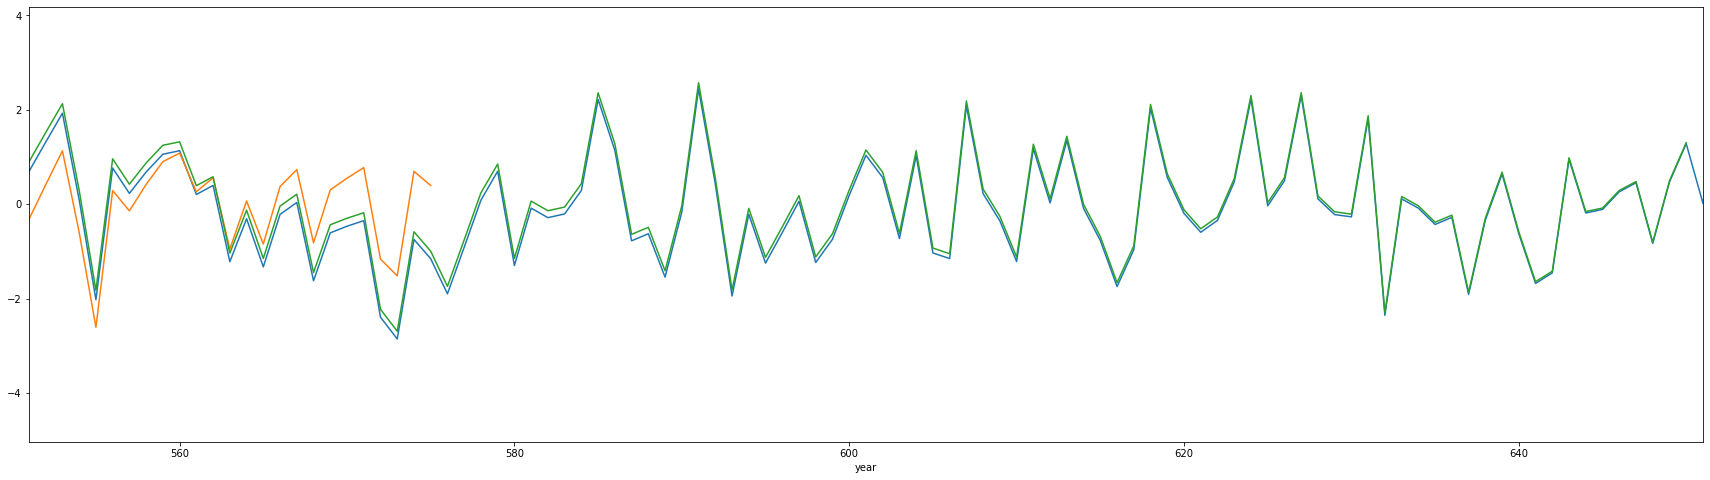

In [149]:
pic_olr_ann_detrend = simple_detrend(pic_olr_ann,dim='year')

fig,ax = plt.subplots(1,1,figsize=(30,8))

ax.plot(pic_olr_ann.year,pic_olr_ann-pic_olr_ann.mean())
# ax.plot(pic_olr_ann_detrend.year,pic_olr_ann_detrend)
# ax.plot(pic_olr_sep.year,pic_olr_sep)
# ax.plot(pic_olr_apr.year,pic_olr_apr)

pic_olr_ann_detrend_551_575 = simple_detrend(pic_olr_ann.sel(year=slice(551,575)),dim='year')
(pic_olr_ann_detrend_551_575).plot()

pic_olr_ann_detrend_551_650 = simple_detrend(pic_olr_ann.sel(year=slice(551,650)),dim='year')
(pic_olr_ann_detrend_551_650).plot()

# pic_olr_ann_551_570 = pic_olr_ann.sel(year=slice(551,570))

# (pic_olr_ann_551_570-pic_olr_ann_551_570.mean()).plot()

ax.set_xlim(551,651)

In [132]:
real_stddev = pic_olr_ann.sel(year=slice(551,575)).std()
real_lag1   = calc_lag1_autocorr(pic_olr_ann.sel(year=slice(551,575)))
real_tauvar = (1+real_lag1) / (1-real_lag1)

print('Real 551-575 std. dev. %.2f' % real_stddev)
print('Real 551-575 $t_{var}$ %.2f' % real_tauvar)

pic_olr_ann_detrend_551_575 = simple_detrend(pic_olr_ann.sel(year=slice(551,575)),dim='year')

corr_stddev = pic_olr_ann_detrend_551_575.std()
corr_lag1   = calc_lag1_autocorr(pic_olr_ann_detrend_551_575)
corr_tauvar = (1+corr_lag1) / (1-corr_lag1)

print('Detrended 551-575 std. dev. %.2f' % corr_stddev)
print('Detrended 551-575 $t_{var}$ %.2f' % corr_tauvar)

Real 551-575 std. dev. 1.17
Real 551-575 $t_{var}$ 2.60
Detrended 551-575 std. dev. 0.89
Detrended 551-575 $t_{var}$ 1.14


In [135]:
real_stddev = pic_olr_ann.sel(year=slice(551,600)).std()
real_lag1   = calc_lag1_autocorr(pic_olr_ann.sel(year=slice(551,600)))
real_tauvar = (1+real_lag1) / (1-real_lag1)

print('Real 551-600 std. dev. %.2f' % real_stddev)
print('Real 551-600 $t_{var}$ %.2f' % real_tauvar)

pic_olr_ann_detrend_551_600 = simple_detrend(pic_olr_ann.sel(year=slice(551,600)),dim='year')

corr_stddev = pic_olr_ann_detrend_551_600.std()
corr_lag1   = calc_lag1_autocorr(pic_olr_ann_detrend_551_600)
corr_tauvar = (1+corr_lag1) / (1-corr_lag1)

print('Detrended 551-600 std. dev. %.2f' % corr_stddev)
print('Detrended 551-600 $t_{var}$ %.2f' % corr_tauvar)

Real 551-600 std. dev. 1.13
Real 551-600 $t_{var}$ 2.10
Detrended 551-600 std. dev. 1.11
Detrended 551-600 $t_{var}$ 2.01


In [134]:
real_stddev = pic_olr_ann.sel(year=slice(551,650)).std()
real_lag1   = calc_lag1_autocorr(pic_olr_ann.sel(year=slice(551,650)))
real_tauvar = (1+real_lag1) / (1-real_lag1)

print('Real 551-650 std. dev. %.2f' % real_stddev)
print('Real 551-650 $t_{var}$ %.2f' % real_tauvar)

pic_olr_ann_detrend_551_650 = simple_detrend(pic_olr_ann.sel(year=slice(551,650)),dim='year')

corr_stddev = pic_olr_ann_detrend_551_650.std()
corr_lag1   = calc_lag1_autocorr(pic_olr_ann_detrend_551_650)
corr_tauvar = (1+corr_lag1) / (1-corr_lag1)

print('Detrended 551-650 std. dev. %.2f' % corr_stddev)
print('Detrended 551-650 $t_{var}$ %.2f' % corr_tauvar)

Real 551-650 std. dev. 1.11
Real 551-650 $t_{var}$ 1.47
Detrended 551-650 std. dev. 1.11
Detrended 551-650 $t_{var}$ 1.47


In [150]:
real_stddev = pic_olr_ann.std()
real_lag1   = calc_lag1_autocorr(pic_olr_ann)
real_tauvar = (1+real_lag1) / (1-real_lag1)

print('Real 400-2200 std. dev. %.2f' % real_stddev)
print('Real 400-2200 $t_{var}$ %.2f' % real_tauvar)

Real 400-2200 std. dev. 1.15
Real 400-2200 $t_{var}$ 1.55


Text(0.5, 0, 'Years')

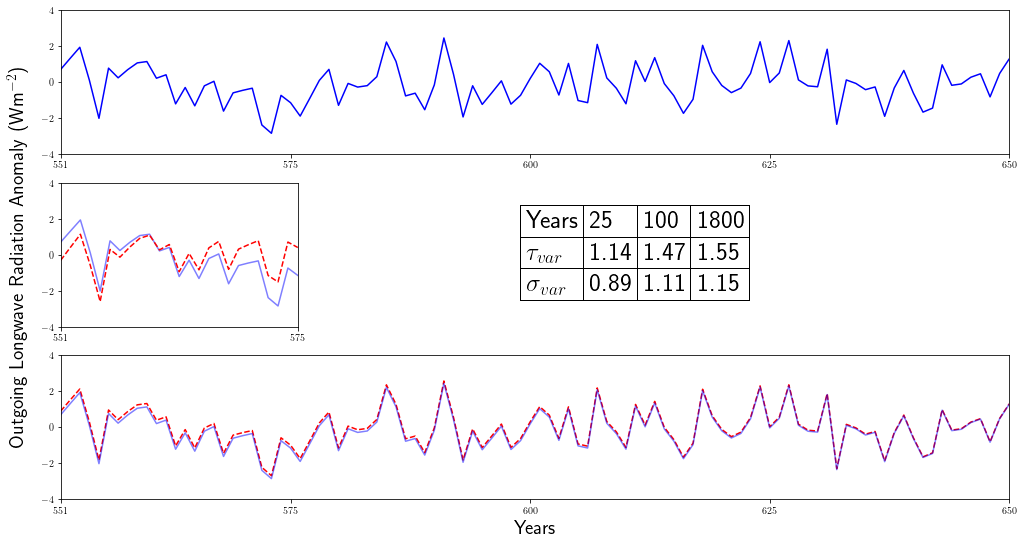

In [244]:
from imports import mpl

mpl.rc('text', usetex=True)

# fig,ax = plt.subplots(1,1,figsize=(10,10),constrained_layout=False)
fig = plt.figure(constrained_layout=False,figsize=(17,9))
fig.subplots_adjust(wspace=0)

gs = gridspec.GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1, 0])
# ax2b = fig.add_subplot(gs[1, 1:])
# ax2b.patch.set_alpha(0.01)
ax3 = fig.add_subplot(gs[2, :])

pic_olr_ann_norm = pic_olr_ann-pic_olr_ann.mean()
pic_olr_ann_norm_551_575 = pic_olr_ann_norm.sel(year=slice(551,575))
pic_olr_ann_norm_551_650 = pic_olr_ann_norm.sel(year=slice(551,650))

ax1.plot(pic_olr_ann_norm.year,pic_olr_ann_norm,color='blue')
ax1.set_xlim(551,650)
ax1.set_ylim(-4,4)
ax1.set_xticks([551,575,600,625,650])

pic_olr_ann_detrend_551_575 = simple_detrend(pic_olr_ann.sel(year=slice(551,575)),dim='year')
# (pic_olr_ann_detrend_551_575).plot()
ax2.plot(pic_olr_ann_norm_551_575.year,pic_olr_ann_norm_551_575,color='blue',alpha=0.5)
ax2.plot(pic_olr_ann_detrend_551_575['year'],pic_olr_ann_detrend_551_575,color='red',linestyle='dashed')
ax2.set_xlim(551,575)
ax2.set_ylim(-4,4)
ax2.set_xticks([551,575])

pic_olr_ann_detrend_551_650 = simple_detrend(pic_olr_ann.sel(year=slice(551,650)),dim='year')
ax3.plot(pic_olr_ann_detrend_551_650['year'],pic_olr_ann_detrend_551_650,color='red',linestyle='dashed')
ax3.plot(pic_olr_ann_norm_551_650['year'],pic_olr_ann_norm_551_650,color='blue',alpha=0.5)
ax3.set_xlim(551,650)
ax3.set_ylim(-4,4)
ax3.set_xticks([551,575,600,625,650])

# (pic_olr_ann_detrend_551_650).plot()

col_labels=['col1','col2','col3']
row_labels=['row1','row2','row3']
table_vals=[[11,12,13],[21,22,23],[31,32,33]]

# Wish I could figure out a way to make this a multiline string..
table = r'''\begin{tabular}{|l|l|l|l|} \hline Years & 25 & 100 & 1800 \\ \hline $\tau_{var}$ & 1.14 & 1.47 & 1.55 \\ \hline $\sigma_{var}$ & 0.89 & 1.11 & 1.15 \\ \hline \end{tabular}
'''

fig.text(0.5,0.40,table,size=25)
fig.text(0.09,0.5,rotation=90,s='Outgoing Longwave Radiation Anomaly (Wm$^{-2}$)',fontsize=20,va='center',ha='center')
ax3.set_xlabel('Years',fontsize=20)

In [210]:
from imports import mpl

mpl.rc('text', usetex=True)

(400.0, 1000.0)

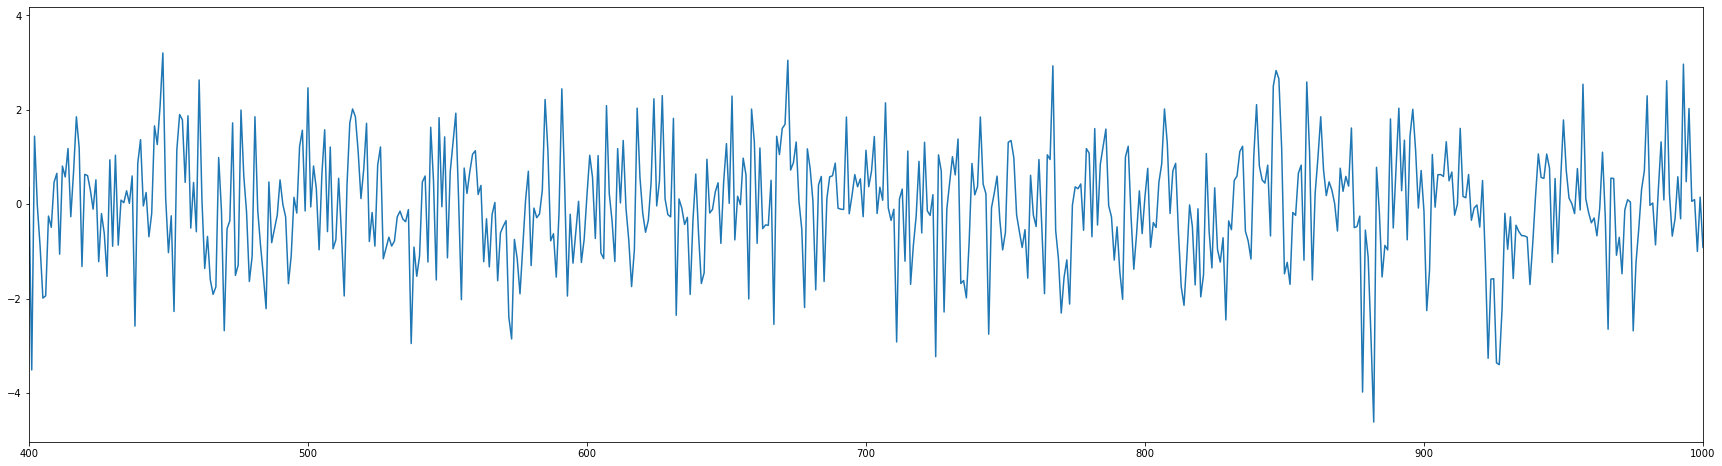

In [109]:
pic_olr_ann_detrend = simple_detrend(pic_olr_ann,dim='year')

fig,ax = plt.subplots(1,1,figsize=(30,8))

ax.plot(pic_olr_ann.year,pic_olr_ann-pic_olr_ann.mean())
# ax.plot(pic_olr_ann_detrend.year,pic_olr_ann_detrend)
# ax.plot(pic_olr_sep.year,pic_olr_sep)
# ax.plot(pic_olr_apr.year,pic_olr_apr)

ax.set_xlim(400,1000)

(400.0, 2200.0)

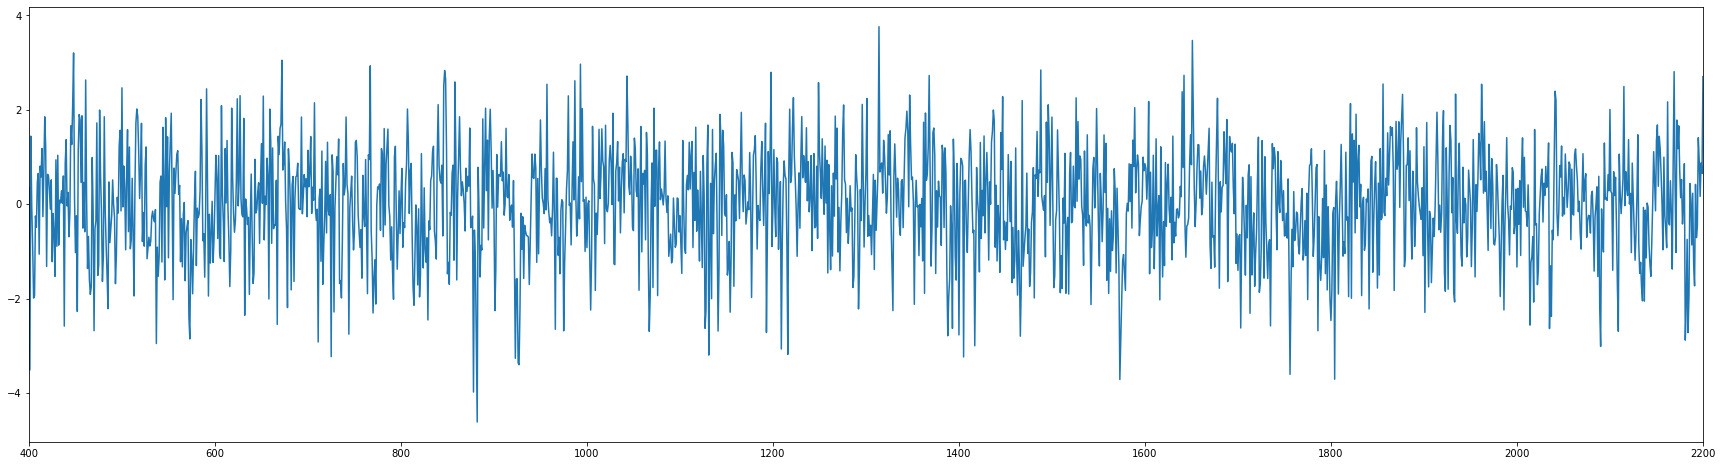

In [108]:
pic_olr_ann_detrend = simple_detrend(pic_olr_ann,dim='year')

fig,ax = plt.subplots(1,1,figsize=(30,8))

ax.plot(pic_olr_ann.year,pic_olr_ann-pic_olr_ann.mean())
# ax.plot(pic_olr_ann_detrend.year,pic_olr_ann_detrend)
# ax.plot(pic_olr_sep.year,pic_olr_sep)
# ax.plot(pic_olr_apr.year,pic_olr_apr)

ax.set_xlim(400,2200)

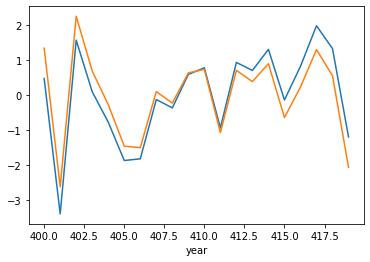

In [97]:

pic_olr_ann_detrend_400_419 = simple_detrend(pic_olr_ann.sel(year=slice(400,419)),dim='year')
pic_olr_ann_400_419 = pic_olr_ann.sel(year=slice(400,419))

(pic_olr_ann_400_419-pic_olr_ann_400_419.mean()).plot()
(pic_olr_ann_detrend_400_419).plot()

In [99]:
pic_olr_ann_400_419.std()

<xarray.DataArray 'FLUT' ()>
array(1.31034802)

In [98]:
pic_olr_ann_detrend_400_419.std()

<xarray.DataArray ()>
array(1.20103253)

In [100]:
calc_lag1_autocorr(pic_olr_ann_400_419)

<xarray.DataArray ()>
array(0.02469214)

In [102]:
calc_lag1_autocorr(pic_olr_ann_detrend_400_419)

<xarray.DataArray ()>
array(-0.24464125)

In [ ]:
# https://stackoverflow.com/questions/66822347/ellipse-95-confidence-interval-in-python

def confidence_ellipse(x,y,ax,n_std=3,facecolor='none',**kwargs):

    """

    Create a plot of the covariance confidence ellipse of *x* and *y*,
    Parameters
    -----------
    x, y: array-like, shape (n,)
        Input data
    ax: matplotlib.axes.Axes
        The axes object to draw the ellipse into
    n_std: float
        The number of standart deviations to determine the ellipse's radiuses.
    **kwargs
            Forward to '~matplotlib.patches.Ellipse'
    
    Returns
    -----------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x,y)
    pearson = cov[0,1]/np.sqrt(cov[0,0] * cov[1,1])
    # Using a special case to obtain the eigenvalues of this two-dimensional dataset
    ell_radius_x = np.sqrt(1+pearson)
    ell_radius_y = np.sqrt(1-pearson)
    ellipse = Ellipse((0,0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    # Calculating the standart deviation of x from the square root of the variance
    # and multiplying with the given number of std deviation
    
    scale_x = np.sqrt(cov[0,0]) * n_std
    mean_x = np.mean(x)
    
    # Calculating the std deviation of y...
    scale_y = np.sqrt(cov[1,1]) * n_std
    mean_y = np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x,scale_y) \
        .translate(mean_x,mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)